# Exploratory Data Analysis

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2  # for image processing
from PIL import Image
import os
import random
import warnings

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, TimeDistributed
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, applications
from keras_tuner import RandomSearch
from tensorflow.keras.applications import VGG16


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_auc_score, roc_curve, precision_recall_curve, PrecisionRecallDisplay, average_precision_score
import matplotlib.pyplot as plt

In [27]:
random.seed(123)
warnings.filterwarnings('ignore')

## Data Exploration

In [28]:
healthy_filepath = "Brain Tumor Data Set\Brain Tumor Data Set\Healthy"
unhealthy_filepath = "Brain Tumor Data Set\Brain Tumor Data Set\Brain Tumor"

healthy_count = len(os.listdir(healthy_filepath))
unhealthy_count = len(os.listdir(unhealthy_filepath))

print(f"Healthy Images: {healthy_count}, Unhealthy Images: {unhealthy_count}")

Healthy Images: 2087, Unhealthy Images: 2513


## Load Images

In [29]:
# standardize all of the images
def load_images_from_folder(folder, label, image_size=(128, 128)):
    images = []
    labels = []
    for filename in os.listdir(folder):
        filepath = os.path.join(folder, filename)
        try: 
            img = cv2.imread(filepath)
            if img is not None: # if openCV can't read the image try with PIL
                img = Image.open(filepath)
                img = img.convert("RGB") # convert to RGB in case of grayscale or RGBA
                img = np.array(img)

            img = cv2.resize(img, image_size)
            images.append(img)
            labels.append(label)
        
        except Exception as e:
            print(f"Error loading {filename}: {e}")
            continue  # Skip unreadable images
            
    return images, labels

In [30]:
# create arrays for images and labels
healthy_images, healthy_labels = load_images_from_folder(healthy_filepath, label = 0)
unhealthy_images, unhealthy_labels = load_images_from_folder(unhealthy_filepath, label = 1)

## Image Preprocessing

In [31]:
X = np.array(healthy_images + unhealthy_images) / 255.0
y = np.array(healthy_labels + unhealthy_labels)

**X explained:**
    This helps normalize the pixel values from their original range of [0, 255] to [0,1]. Normalizing helps the model learn more efficiently and can lead to better training results since most neural networks work better with normalized data. 
    


In [32]:
# Data Augmentation
data_gen = ImageDataGenerator(
    rotation_range=5,      # Smaller rotation range
    zoom_range=0.1,        # Small zoom to avoid losing details
    width_shift_range=0.05, # Small shifts to keep important features within the frame
    height_shift_range=0.05,
    fill_mode="nearest"
)


**Data Augmentation:** Is meant to help prevent overfitting. 
* Rotation Range: randomly rotates images up to 20 degress which helps the model gereralize to slightly rotated images.
* Zoom Range: randomly zooms in or out on images by up to 15% which helps the model learn to recognize images at different scales.
* Width Shift Range and Height Shift Range: Randomly shifts images horizontally and vertically by up to 20%. This helps the model generalize slightly to images that may not be perfectly centered.
* Shear Range: Shear transformation means essentially "slanting" the image by up to 15% which helps robustness with slight distortions.
* Fill Mode: Speicifies how to fill in new pixel values when shifting, zooming, or rotating an image. 

## Split Data

In [33]:
# Separate healthy and unhealthy data based on labels
X_healthy = X[y == 0]
X_unhealthy = X[y == 1]

# Define the sizes for each set based on the 70/20/10 split
# 70% Training, 20% Validation, 10% Testing
train_size_per_class = int(len(X_healthy) * 0.7)  # 70% of each class
val_size_per_class = int(len(X_healthy) * 0.2)    # 20% of each class
test_size_healthy = int(len(X_healthy) * 0.08)     # 80% of test set is healthy (0.8 * 10%)
test_size_unhealthy = int(len(X_unhealthy) * 0.02) # 20% of test set is unhealthy (0.2 * 10%)

# Step 1: Training Set - 70% of total data, balanced 50/50 between healthy and unhealthy
X_train = np.concatenate((X_healthy[:train_size_per_class], X_unhealthy[:train_size_per_class]))
y_train = np.array([0] * train_size_per_class + [1] * train_size_per_class)

# Step 2: Validation Set - 20% of total data, balanced 50/50 between healthy and unhealthy
X_val = np.concatenate((X_healthy[train_size_per_class:train_size_per_class + val_size_per_class], 
                        X_unhealthy[train_size_per_class:train_size_per_class + val_size_per_class]))
y_val = np.array([0] * val_size_per_class + [1] * val_size_per_class)

# Step 3: Testing Set - 10% of total data, with an 80/20 split
X_test = np.concatenate((X_healthy[train_size_per_class + val_size_per_class:train_size_per_class + val_size_per_class + test_size_healthy], 
                         X_unhealthy[train_size_per_class + val_size_per_class:train_size_per_class + val_size_per_class + test_size_unhealthy]))
y_test = np.array([0] * test_size_healthy + [1] * test_size_unhealthy)

# Verification
print("Training set:", len(X_train), len(y_train))  # Expected: 70% of total
print("Validation set:", len(X_val), len(y_val))    # Expected: 20% of total
print("Testing set:", len(X_test), len(y_test))      # Expected: 10% of total with 80/20 class split
print("Testing set class distribution:", "Healthy:", sum(y_test == 0), "Tumor:", sum(y_test == 1))  # Expected: 80% healthy, 20% tumor


Training set: 2920 2920
Validation set: 834 834
Testing set: 416 416


**Training Set (2760 Images):**
* We select the first 1380 healthy and the first 1380 unhealthy images to ensure a 50/50 split.

**Validation Set (1380 Images):**
* We select the next 1104 healthy images and 276 unhealthy images to achieve an 80/20 split.

**Testing Set (460 Images):**
* Finally, we select the next 368 healthy images and 92 unhealthy images to meet the 80/20 split.

# CNN-LSTM

In [34]:
# Changing shape so tensor sees same shape across all layers of both nets
X_train_expanded = np.expand_dims(X_train, axis=1)  # Shape becomes (batch_size, 1, 128, 128, 3)
X_val_expanded = np.expand_dims(X_val, axis=1)      # Same for validation set

def build_model(hp):
    model = Sequential()
    
    # Define input shape as (1, 128, 128, 3) in TimeDistributed
    model.add(TimeDistributed(Conv2D(
        filters=hp.Int('conv_filters', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('kernel_size', values=[3, 5]),
        activation='relu',
        padding='same'  # Add padding to retain spatial dimensions
    ), input_shape=(1, 128, 128, 3)))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    
    model.add(TimeDistributed(Conv2D(
        filters=hp.Int('conv_filters_2', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('kernel_size_2', values=[3, 5]),
        activation='relu',
        padding='same'  # Add padding here as well
    )))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(units=hp.Int('lstm_units', min_value=32, max_value=128, step=32), return_sequences=False))
    model.add(Dropout(rate=hp.Float('dropout', 0.1, 0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=tf.keras.optimizers.Adam(
                      learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model



In [35]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='cnn_lstm_tuning',  # create a new directory for tuning
    project_name='cnn_lstm_project'
)


Reloading Tuner from cnn_lstm_tuning\cnn_lstm_project\tuner0.json


In [36]:
# search for the best hyperparameters
print("X_train shape:", X_train.shape)  # Should be (batch_size, 1, 128, 128, 3)
print("X_val shape:", X_val.shape)      # Should be (batch_size, 1, 128, 128, 3)
tuner.search(X_train_expanded, y_train, epochs=10, validation_data = (X_val_expanded, y_val))

Trial 14 Complete [00h 03m 16s]
val_accuracy: 0.8105515837669373

Best val_accuracy So Far: 0.9740740656852722
Total elapsed time: 01h 08m 52s


In [37]:
# get best model
best_model = tuner.get_best_models(num_models=1)[0]

# get the best hyperparameters
best_parm = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:")
print(f"Conv Filters 1: {best_parm.get('conv_filters')}")
print(f"Kernel Size 1: {best_parm.get('kernel_size')}")
print(f"Conv Filters 2: {best_parm.get('conv_filters_2')}")
print(f"Kernel Size 2: {best_parm.get('kernel_size_2')}")
print(f"LSTM Units: {best_parm.get('lstm_units')}")
print(f"Learning Rate: {best_parm.get('learning_rate')}")
print(f"Dropout: {best_parm.get('dropout')}")

Best hyperparameters:
Conv Filters 1: 32
Kernel Size 1: 3
Conv Filters 2: 96
Kernel Size 2: 5
LSTM Units: 128
Learning Rate: 0.001
Dropout: 0.4


In [38]:
X_test_expanded = np.expand_dims(X_test, axis=1)  # Shape should now be (batch_size, 1, 128, 128, 3)

# get the testing accuracy and loss
test_loss, test_accuracy = best_model.evaluate(X_test_expanded, y_test)
print("Testing Accuracy: ", test_accuracy)
print("Testing Loss: ", test_loss)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.7524 - loss: 0.7204
Testing Accuracy:  0.6682692170143127
Testing Loss:  0.926200270652771


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
Number of misclassified images: 138


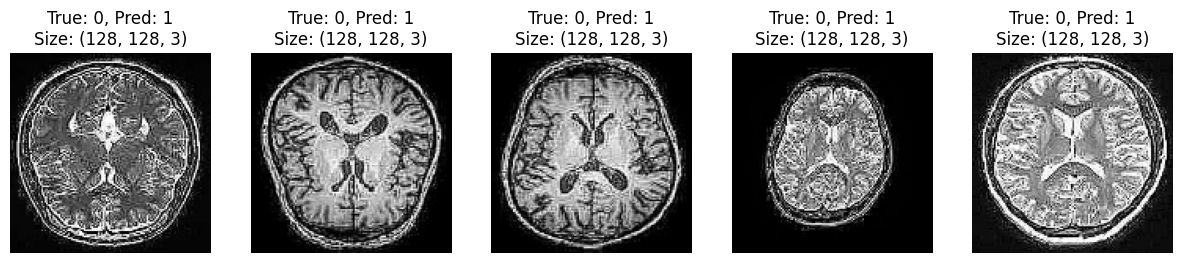

              precision    recall  f1-score   support

           0       0.63      0.84      0.72       208
           1       0.75      0.50      0.60       208

    accuracy                           0.67       416
   macro avg       0.69      0.67      0.66       416
weighted avg       0.69      0.67      0.66       416



In [39]:
# Get model predictions for the test set
y_pred = best_model.predict(X_test_expanded)
y_pred_round = np.round(y_pred).astype(int).flatten()  # Convert probabilities to binary predictions

# Find misclassified images
misclassified_indices = np.where(y_pred_round != y_test)[0]

print(f"Number of misclassified images: {len(misclassified_indices)}")

# Display some of the misclassified images with additional characteristics
num_images_to_display = 5  # Adjust as desired
plt.figure(figsize=(15, 15))

for i, index in enumerate(misclassified_indices[:num_images_to_display]):
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(X_test[index])  # Display RGB image
    image_shape = X_test[index].shape  # Get image dimensions (height, width, channels)
    plt.title(f"True: {y_test[index]}, Pred: {y_pred_round[index]}\nSize: {image_shape}")
    plt.axis('off')

plt.show()

# Generate classification report and confusion matrix
print(classification_report(y_test, y_pred_round))
confusionMatrix = confusion_matrix(y_test, y_pred_round)

## Visualize Confusion Matrix

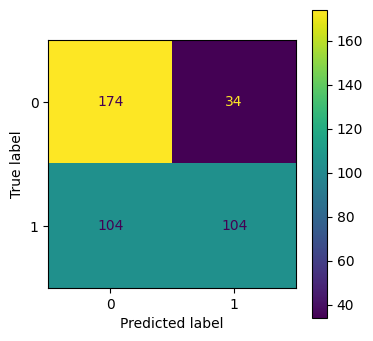

In [40]:
# plot the confusion matrix
confusionMatrixPlot = ConfusionMatrixDisplay(confusion_matrix = confusionMatrix)
plt.figure(figsize=(4, 4))
confusionMatrixPlot.plot(ax=plt.gca())
plt.show()

## ROC Curve

In [41]:
# compute the AUC value
aucValue = roc_auc_score(y_test, y_pred)

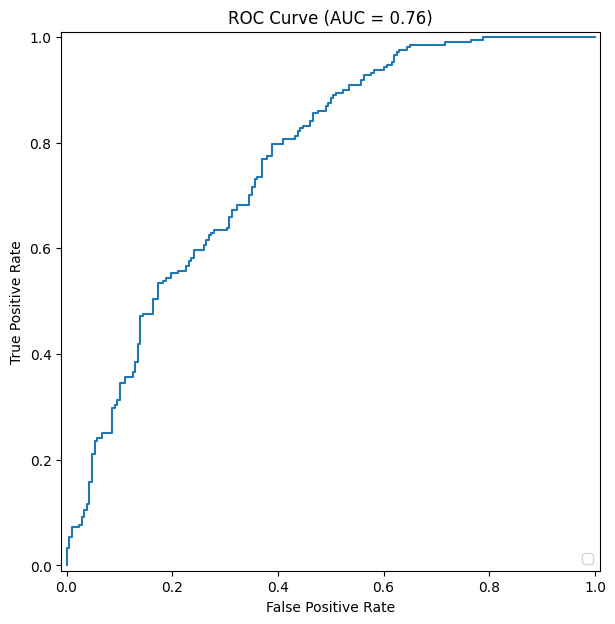

In [42]:
# plot the ROC
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure(figsize=(7, 7))
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
roc_display.plot(ax=plt.gca())
plt.title(f"ROC Curve (AUC = {aucValue:.2f})")
plt.show()

## Precision-Recall Curve

In [43]:
# compute the precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
average_precision = average_precision_score(y_test, y_pred)

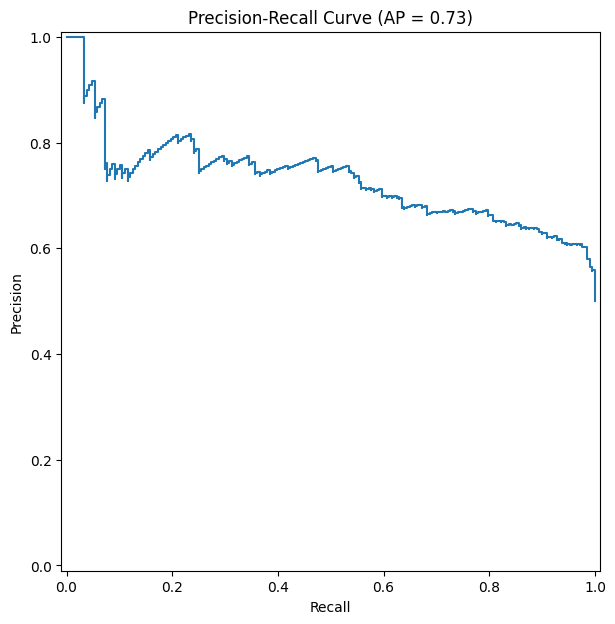

In [44]:
# plot the PRC
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure(figsize=(7, 7))
PRC_display = PrecisionRecallDisplay(precision= precision, recall=recall)
PRC_display.plot(ax=plt.gca())
plt.title(f"Precision-Recall Curve (AP = {average_precision:.2f})")
plt.show()